In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
from scipy import sparse

import matplotlib.pyplot as plt

import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sc.set_figure_params(figsize=(4, 4))

In [3]:
adata1 = sc.read_h5ad('../data/simulate1.h5ad')
adata2 = sc.read_h5ad('../data/simulate2.h5ad')
adata3 = sc.read_h5ad('../data/simulate3.h5ad')
adata1, adata2, adata3

(AnnData object with n_obs × n_vars = 1000 × 500
     obs: 'celltype', 'batch', 'slice_name', 'batch_name'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 1000 × 500
     obs: 'celltype', 'batch', 'slice_name', 'batch_name'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 825 × 500
     obs: 'celltype', 'batch', 'slice_name', 'batch_name'
     obsm: 'spatial')

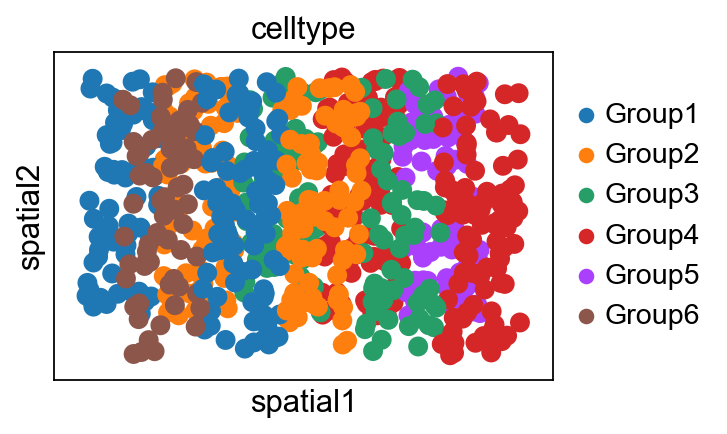

In [4]:
adata = adata3.copy()
sc.pl.spatial(adata, color=['celltype'], spot_size=0.5)

In [5]:
from scipy.sparse import csr_matrix

def rotation_matrix(degrees):
    radians = np.deg2rad(degrees)
    c, s = np.cos(radians), np.sin(radians)
    return np.array([[c, -s], [s, c]])

def rotate_matrix(coords, degrees):
    R = rotation_matrix(degrees)
    return np.dot(coords, R)

def add_gaussian_noise(matrix, noise_level=0.01):
    mean_noise = 0
    std_noise = noise_level * np.std(matrix[matrix != 0])
    noise = np.abs(np.random.normal(mean_noise, std_noise, matrix.shape))

    noisy_matrix = matrix + noise
    noisy_matrix[matrix != 0] += noise[matrix != 0]
    return csr_matrix(noisy_matrix)

In [6]:
adata_sub1 = adata[adata.obs['batch'] == 'Batch1']
adata_sub2 = adata[adata.obs['batch'] == 'Batch2']
adata_sub1, adata_sub2

(View of AnnData object with n_obs × n_vars = 424 × 500
     obs: 'celltype', 'batch', 'slice_name', 'batch_name'
     uns: 'celltype_colors'
     obsm: 'spatial',
 View of AnnData object with n_obs × n_vars = 401 × 500
     obs: 'celltype', 'batch', 'slice_name', 'batch_name'
     uns: 'celltype_colors'
     obsm: 'spatial')

### We fix slice1 and rotate slice2

In [7]:
# rotate_180 = rotate_matrix(adata_sub1.obsm['spatial'], 180)
# adata_sub1.obsm['spatial'] = rotate_180
# noisy_matrix = add_gaussian_noise(adata_sub2.X, noise_level=2.5)
# adata_sub2.X = noisy_matrix

In [8]:
adata = ad.concat([adata_sub1, adata_sub2])

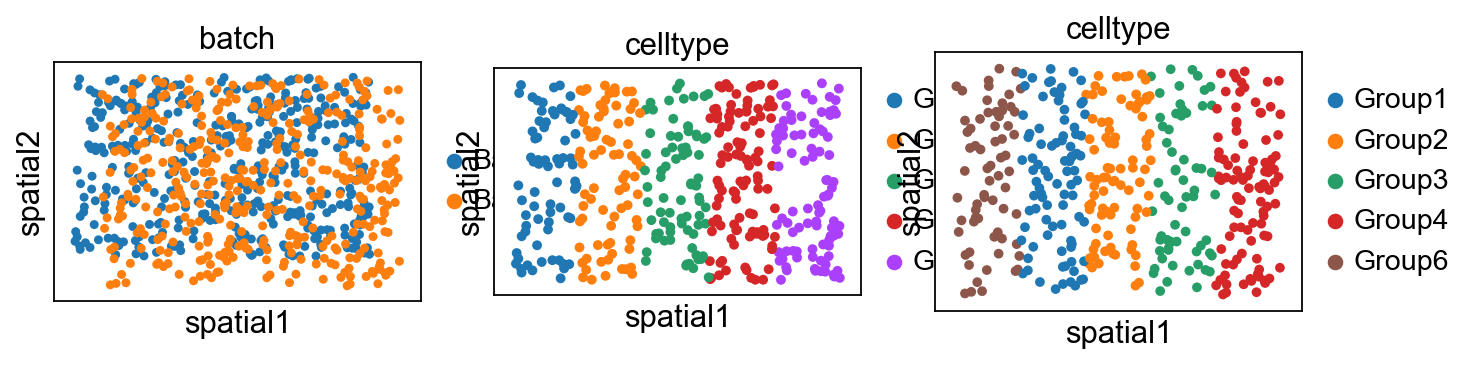

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 35))
sc.pl.spatial(adata, spot_size=0.3, color=['batch'], show=False, ax=axes[0])
sc.pl.spatial(adata_sub1, color=['celltype'], spot_size=0.3, show=False, ax=axes[1])
sc.pl.spatial(adata_sub2, color=['celltype'], spot_size=0.3, show=False, ax=axes[2])
plt.show()

In [10]:
adata1_harm_df = pd.DataFrame({
    'index': range(adata_sub1.shape[0]),
    'x': adata_sub1.obsm['spatial'][:, 0],
    'y': adata_sub1.obsm['spatial'][:, 1],
    'domain': adata_sub1.obs['celltype'].astype('category'),
})

adata2_harm_df = pd.DataFrame({
    'index': range(adata_sub2.shape[0]),
    'x': adata_sub2.obsm['spatial'][:, 0],
    'y': adata_sub2.obsm['spatial'][:, 1],
    'domain': adata_sub2.obs['celltype'].astype('category'),
})

adata1_harm_df, adata2_harm_df

(         index          x         y  domain
 Cell1        0  10.946707  0.162251  Group5
 Cell2        1   3.054236  2.080283  Group2
 Cell3        2   4.764916  2.351798  Group2
 Cell4        3   3.195386  3.386982  Group2
 Cell5        4   2.910372  1.544777  Group1
 ...        ...        ...       ...     ...
 Cell496    419   8.996239  4.686836  Group4
 Cell497    420   4.113939  0.279649  Group2
 Cell498    421  10.976578  5.939794  Group5
 Cell499    422   4.436878  2.789794  Group2
 Cell500    423   3.858467  1.723020  Group2
 
 [424 rows x 4 columns],
          index          x         y  domain
 Cell501      0   6.767199  5.553187  Group2
 Cell502      1   3.464073  4.354363  Group6
 Cell503      2   5.113886  3.590466  Group1
 Cell505      3   7.071197  3.121924  Group2
 Cell506      4   3.903464  6.228928  Group6
 ...        ...        ...       ...     ...
 Cell993    396   5.264515  2.256674  Group1
 Cell995    397   6.520853  4.345718  Group2
 Cell997    398   3.179237  

## Execute AlignDG

#### Data preparation

In [11]:
from utils.graph_construction import cal_spatial_network

adj_list = []
adata_list = []
section_ids = ['Batch1', 'Batch2']
for section_id in section_ids:
    print(section_id)
    adata = adata3[adata3.obs['batch'] == section_id]
    adata.X = sparse.csc_matrix(adata.X)
    adata.var_names_make_unique(join="++")

    # make spot name unique
    adata.obs_names = [x + '_' + section_id for x in adata.obs_names]

    cal_spatial_network(adata, model='KNN', k_cutoff=2)

    adj_list.append(adata.uns['adj'])
    adata_list.append(adata)

Batch1
Calculating spatial neighbor graph ...
The graph contains 1000 edges, 424 cells
2.358490566037736 neighbors per cell on average
Batch2
Calculating spatial neighbor graph ...
The graph contains 957 edges, 401 cells
2.3865336658354113 neighbors per cell on average


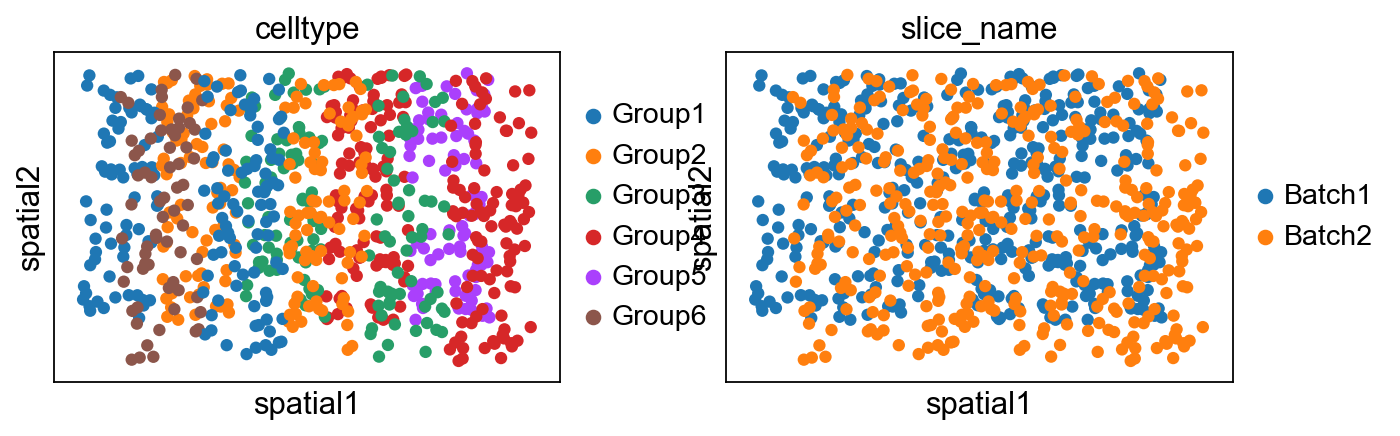

In [12]:
import anndata as ad

adata_concat = ad.concat(adata_list, label='slice_name', keys=section_ids)
sc.pl.spatial(adata_concat, color=['celltype', 'slice_name'], spot_size=0.3)

In [13]:
from scipy.sparse import bmat

adata_concat = ad.concat(adata_list, label='slice_name', keys=section_ids)
adj_concat = bmat([[adj_list[0], None],
                   [None, adj_list[1]]])
adata_concat.uns['edge_list'] = np.nonzero(adj_concat)

In [14]:
def mapping_accuracy(adatas, key_obs, mapping_pi):
    count = 0
    ref_raw_list = []
    index = []
    for i in range(mapping_pi.shape[0]):
        if np.sum(mapping_pi[i] > 0):
            index.append(i)
            source_domain = adatas[0].obs[key_obs][i]
            max_align = mapping_pi[i].argsort()[-1]
            target_domain = adatas[1].obs[key_obs].values[max_align]
            ref_raw_list.append(max_align)
            if source_domain == target_domain:
                count = count + 1

    print(count / len(index))

def retain_top_k(matrix, K):
    K = min(K, matrix.shape[1])

    result = np.zeros_like(matrix)

    indices = np.argpartition(matrix, -K, axis=1)[:, -K:]

    row_indices = np.arange(matrix.shape[0])[:, None]  # Make it column vector
    result[row_indices, indices] = matrix[row_indices, indices]
    return result

In [15]:
adata1_harm_df = pd.DataFrame({
    'index': range(adata_sub1.shape[0]),
    'x': adata_sub1.obsm['spatial'][:, 0],
    'y': adata_sub1.obsm['spatial'][:, 1],
    'domain': adata_sub1.obs['celltype'].astype('category'),
})

adata2_harm_df = pd.DataFrame({
    'index': range(adata_sub2.shape[0]),
    'x': adata_sub2.obsm['spatial'][:, 0],
    'y': adata_sub2.obsm['spatial'][:, 1],
    'domain': adata_sub2.obs['celltype'].astype('category'),
})

adata1_harm_df, adata2_harm_df

(         index          x         y  domain
 Cell1        0  10.946707  0.162251  Group5
 Cell2        1   3.054236  2.080283  Group2
 Cell3        2   4.764916  2.351798  Group2
 Cell4        3   3.195386  3.386982  Group2
 Cell5        4   2.910372  1.544777  Group1
 ...        ...        ...       ...     ...
 Cell496    419   8.996239  4.686836  Group4
 Cell497    420   4.113939  0.279649  Group2
 Cell498    421  10.976578  5.939794  Group5
 Cell499    422   4.436878  2.789794  Group2
 Cell500    423   3.858467  1.723020  Group2
 
 [424 rows x 4 columns],
          index          x         y  domain
 Cell501      0   6.767199  5.553187  Group2
 Cell502      1   3.464073  4.354363  Group6
 Cell503      2   5.113886  3.590466  Group1
 Cell505      3   7.071197  3.121924  Group2
 Cell506      4   3.903464  6.228928  Group6
 ...        ...        ...       ...     ...
 Cell993    396   5.264515  2.256674  Group1
 Cell995    397   6.520853  4.345718  Group2
 Cell997    398   3.179237  

In [16]:
import networkx as nx
from uopt.problems.space import AlignmentProblem
import torch
from torch_geometric.data import Data
from graph.model import GATAutoEncoder
from tqdm import tqdm
import torch.nn.functional as F


alpha = 0.4
tau_a = 0.6
lamb1 = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = Data(edge_index=torch.LongTensor(np.array([adata_concat.uns['edge_list'][0], adata_concat.uns['edge_list'][1]])), prune_edge_index=torch.LongTensor(np.array([])), x=torch.FloatTensor(adata_concat.X.todense()))
data = data.to(device)

model = GATAutoEncoder(hidden_dims=[adata_concat.shape[1], 512, 32]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
model.train()

for _ in tqdm(range(0, 500)):
    optimizer.zero_grad()
    z, out = model(data.x, data.edge_index)
    loss = F.mse_loss(out, data.x)
    loss.backward()
    torch.nn.utils.clip_grad_value_(model.parameters(), 5.0)
    optimizer.step()

with torch.no_grad():
    model.eval()
    z, _ = model(data.x, data.edge_index)
    adata_concat.obsm['raw_latent'] = z.cpu().detach().numpy()
    adata_concat.obsm['latent'] = z.cpu().detach().numpy()

trans_list = []
mnns = dict()
key_name1 = section_ids[0] + '_' + section_ids[1]
mnns[key_name1] = {}

epoch_iter = tqdm(range(500, 700), position=0)
model.train()

for epoch in epoch_iter:
    if epoch % 100 == 0 or epoch == 500:
        print('Update spot triplet at epoch {}'.format(epoch))
        adata_concat.obsm['latent'] = z.cpu().detach().numpy()

        ap = AlignmentProblem(adata=adata_concat)
        ap = ap.prepare(batch_key='slice_name', policy='sequential', joint_attr='latent')
        ap = ap.solve(alpha=alpha, tau_a=tau_a, epsilon=1e-3)
        pi = ap.solutions[list(ap.solutions)[0]].transport_matrix
        rows, cols = np.where(pi > 0)
        mapping = [(adata_list[0].obs_names[row], adata_list[1].obs_names[col]) for row, col in zip(rows, cols)]
        mapping = set(mapping)

        G = nx.Graph()
        G.add_edges_from(mapping)
        node_names = np.array(G.nodes)
        anchors = list(node_names)

        adj = nx.adjacency_matrix(G)
        tmp = np.split(adj.indices, adj.indptr[1: -1])

        for anchor in range(len(anchors)):
            key = anchors[anchor]
            index = tmp[anchor]
            names = list(node_names[index])

            if key in mnns[key_name1]:
                mnns[key_name1][key].extend(x for x in names if x not in mnns[key_name1][key])
            else:
                mnns[key_name1][key] = names

    anchor_ind = []
    positive_ind = []
    negative_ind = []

    for batch_pair in mnns.keys():
        batch_name_list = adata_concat.obs['slice_name'][mnns[batch_pair].keys()]
        cell_name_by_batch_dict = dict()
        for batch_id in range(len(section_ids)):
            cell_name_by_batch_dict[section_ids[batch_id]] = adata_concat.obs_names[adata_concat.obs['slice_name'] == section_ids[batch_id]].values

        anchor_list = []
        positive_list = []
        negative_list = []
        for anchor in mnns[batch_pair].keys():
            # print(anchor, batch_pair)
            anchor_list.append(anchor)
            positive_spot = mnns[batch_pair][anchor][0]
            positive_list.append(positive_spot)
            section_size = len(cell_name_by_batch_dict[batch_name_list[anchor]])
            # print(section_size)
            negative_list.append(cell_name_by_batch_dict[batch_name_list[anchor]][np.random.randint(section_size)])

        batch_as_dict = dict(zip(list(adata_concat.obs_names), range(0, adata_concat.shape[0])))
        anchor_ind = np.append(anchor_ind, list(map(lambda _: batch_as_dict[_], anchor_list)))
        positive_ind = np.append(positive_ind, list(map(lambda _: batch_as_dict[_], positive_list)))
        negative_ind = np.append(negative_ind, list(map(lambda _: batch_as_dict[_], negative_list)))

    z, out = model(data.x, data.edge_index)
    mse_loss = F.mse_loss(out, data.x)

    anchor_arr = z[anchor_ind, ]
    positive_arr = z[positive_ind, ]
    negative_arr = z[negative_ind, ]

    triplet_loss = torch.nn.TripletMarginLoss(margin=1, p=2, reduction='mean')
    tri_output = triplet_loss(anchor_arr, positive_arr, negative_arr)

    loss = mse_loss + lamb1 * tri_output
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.)
    optimizer.step()
    epoch_iter.set_description(f"# Epoch {epoch}, loss: {loss.item():.3f}, gene_recon: {mse_loss.item():.3f}, triplet loss: {tri_output.item()}")

with torch.no_grad():
    model.eval()
    z, out = model(data.x, data.edge_index)
    adata_concat.obsm['latent'] = z.cpu().detach().numpy()

  0%|          | 0/200 [00:00<?, ?it/s]

Update spot triplet at epoch 500
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Normalizing spatial coordinates of `y`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(424, 401)].                                            


# Epoch 599, loss: 1.734, gene_recon: 0.745, triplet loss: 0.1977883279323578:  50%|████▉     | 99/200 [00:04<00:01, 68.24it/s] 

Update spot triplet at epoch 600
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Normalizing spatial coordinates of `y`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(424, 401)].                                            


# Epoch 699, loss: 1.772, gene_recon: 0.970, triplet loss: 0.16031816601753235: 100%|██████████| 200/200 [00:07<00:00, 25.58it/s]


In [17]:
ap = AlignmentProblem(adata=adata_concat)
ap = ap.prepare(batch_key='slice_name', policy='sequential', joint_attr='latent')
ap = ap.solve(alpha=alpha, tau_a=tau_a, epsilon=1e-3)
mapping_pi = ap.solutions[list(ap.solutions)[0]].transport_matrix
count = 0
ref_raw_list = []
index = []

adata_sub1 = adata_concat[adata_concat.obs['slice_name'] == section_ids[0]]
adata_sub2 = adata_concat[adata_concat.obs['slice_name'] == section_ids[1]]
for i in range(mapping_pi.shape[0]):
    if np.sum(mapping_pi[i] > 0):
        index.append(i)
        source_domain = adata_sub1.obs['celltype'][i]
        max_align = mapping_pi[i].argsort()[-1]
        target_domain = adata_sub2.obs['celltype'].values[max_align]
        ref_raw_list.append(max_align)
        if source_domain == target_domain:
            count = count + 1

print(count / len(ref_raw_list), count, len(ref_raw_list))

index_harm = np.array(ref_raw_list)
matching_harm = np.array([index, index_harm])

INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Normalizing spatial coordinates of `y`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(424, 401)].                                            
0.8468468468468469 282 333


dataset1: 5 cell types; dataset2: 5 cell types; 
                    Total :6 celltypes; Overlap: 4 cell types 
                    Not overlap :[['Group6', 'Group5']]
Subsampled 150 pairs from 333


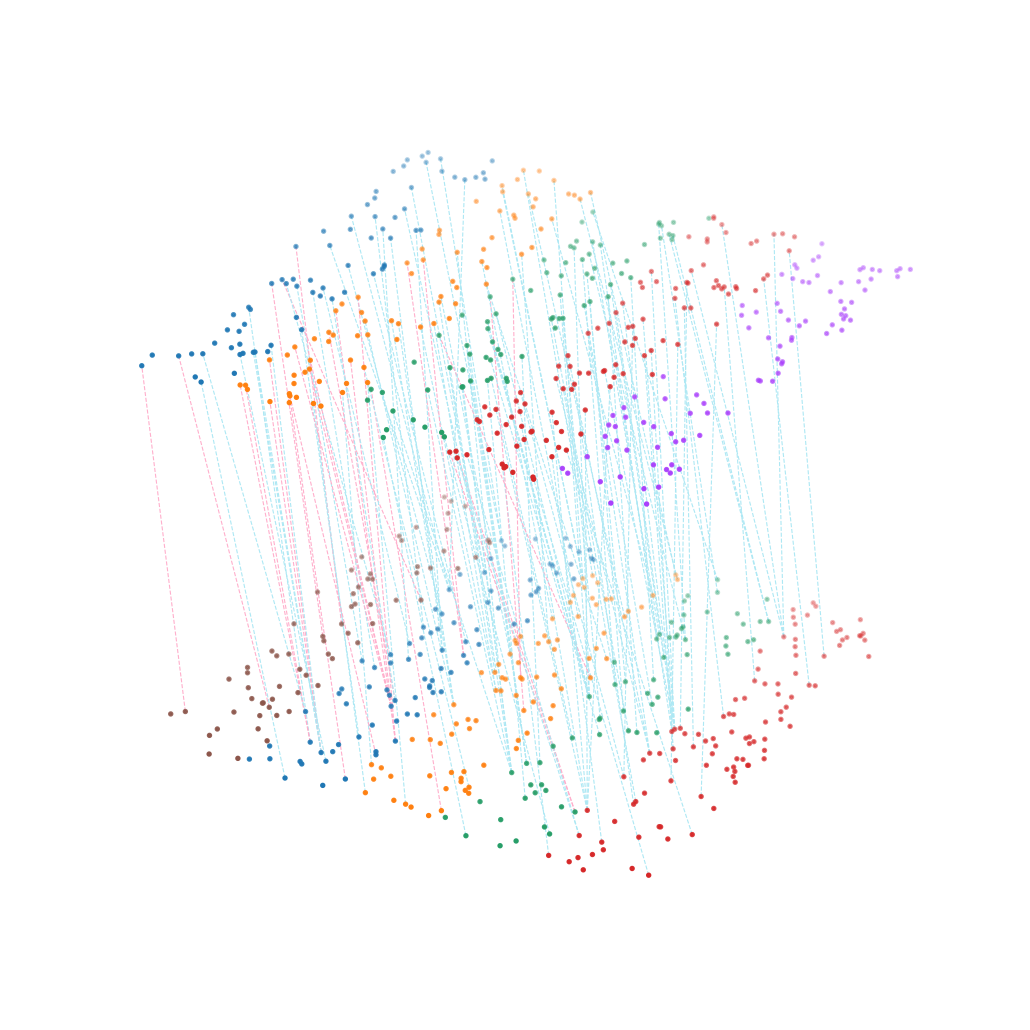

In [18]:
from utils.visualize import Build3D

multi_align = Build3D(adata2_harm_df, adata1_harm_df, matching_harm, meta='domain', scale_coordinate=True,subsample_size=150, exchange_xy=False)
multi_align.draw_3D(size=[8, 10], line_width=0.5, point_size=[2, 2], line_alpha=1, hide_axis=True, show_error=True)

In [19]:
sc.pp.neighbors(adata_concat, use_rep='latent')
sc.tl.umap(adata_concat)

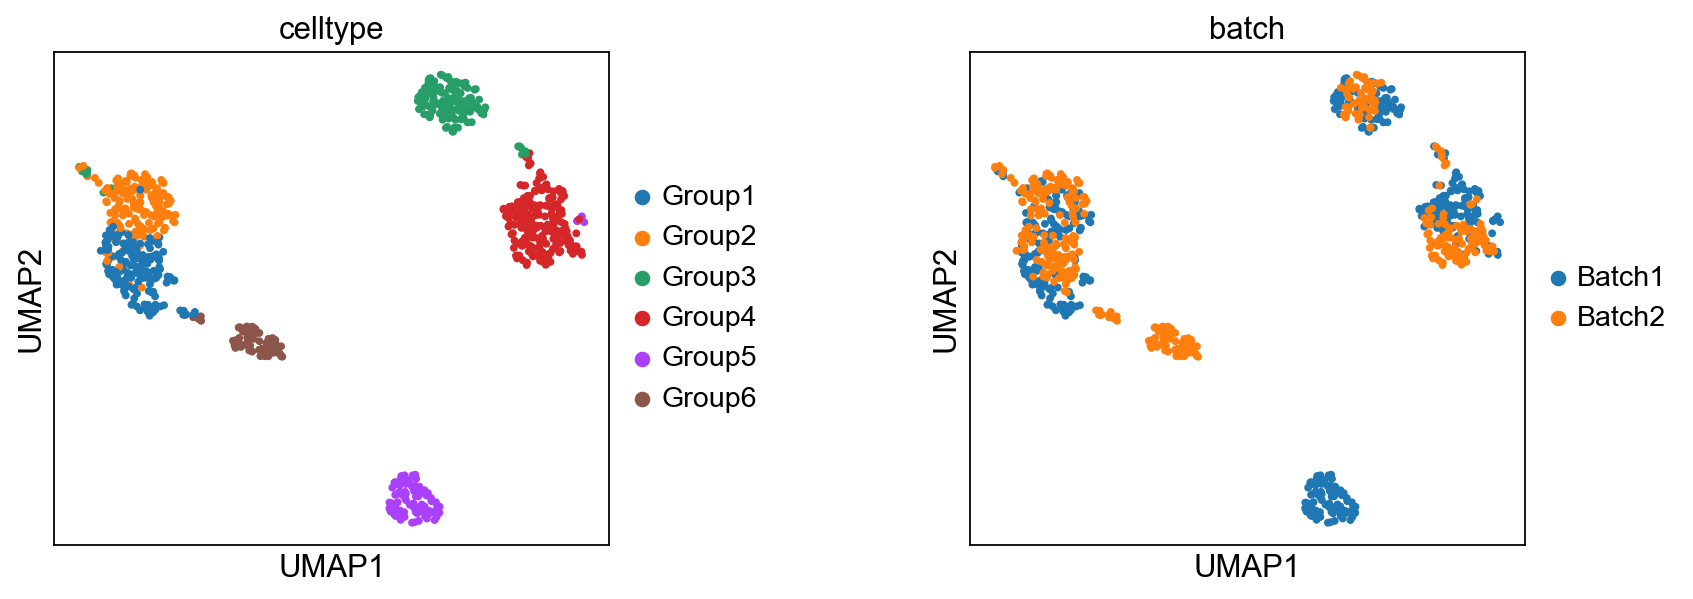

In [20]:
sc.pl.umap(adata_concat, color=['celltype', 'batch'], size=50, wspace=0.5)

### moscot Part

In [21]:
from uopt.problems.space import AlignmentProblem

ap = AlignmentProblem(adata=adata3)
ap = ap.prepare(batch_key='slice_name', policy='sequential', )
ap = ap.solve(alpha=0.4, tau_a=0.6, epsilon=1e-3)

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Normalizing spatial coordinates of `y`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(424, 401)].                                            


In [22]:
adata_sub1 = adata3[adata3.obs['batch'] == 'Batch1']
adata_sub2 = adata3[adata3.obs['batch'] == 'Batch2']

In [23]:
adata1_harm_df = pd.DataFrame({
    'index': range(adata_sub1.shape[0]),
    'x': adata_sub1.obsm['spatial'][:, 0],
    'y': adata_sub1.obsm['spatial'][:, 1],
    'domain': adata_sub1.obs['celltype'].astype('category'),
})

adata2_harm_df = pd.DataFrame({
    'index': range(adata_sub2.shape[0]),
    'x': adata_sub2.obsm['spatial'][:, 0],
    'y': adata_sub2.obsm['spatial'][:, 1],
    'domain': adata_sub2.obs['celltype'].astype('category'),
})

adata1_harm_df, adata2_harm_df

(         index          x         y  domain
 Cell1        0  10.946707  0.162251  Group5
 Cell2        1   3.054236  2.080283  Group2
 Cell3        2   4.764916  2.351798  Group2
 Cell4        3   3.195386  3.386982  Group2
 Cell5        4   2.910372  1.544777  Group1
 ...        ...        ...       ...     ...
 Cell496    419   8.996239  4.686836  Group4
 Cell497    420   4.113939  0.279649  Group2
 Cell498    421  10.976578  5.939794  Group5
 Cell499    422   4.436878  2.789794  Group2
 Cell500    423   3.858467  1.723020  Group2
 
 [424 rows x 4 columns],
          index          x         y  domain
 Cell501      0   6.767199  5.553187  Group2
 Cell502      1   3.464073  4.354363  Group6
 Cell503      2   5.113886  3.590466  Group1
 Cell505      3   7.071197  3.121924  Group2
 Cell506      4   3.903464  6.228928  Group6
 ...        ...        ...       ...     ...
 Cell993    396   5.264515  2.256674  Group1
 Cell995    397   6.520853  4.345718  Group2
 Cell997    398   3.179237  

In [24]:
# 越不平衡 (值越小)，则边越少
pi = list(ap.solutions.values())[0].transport_matrix
np.sum(pi > 0, axis=1)

Array([ 0, 23, 24, 42, 39, 40,  0,  6, 47, 48, 18, 26, 15, 17,  9, 24, 61,
        0,  7, 11, 18,  0,  0,  3, 41,  5,  0,  3,  2, 30, 22,  0, 35,  1,
       27, 29, 37,  8, 25, 21, 10, 58, 10, 56,  0,  3,  3,  0, 11,  2,  0,
       14,  0, 43,  0,  7,  2, 17,  0, 66,  0, 54,  0,  0,  5, 58,  0, 23,
       11, 30, 21,  0,  6,  0, 43,  1,  3,  0, 22,  0, 41,  0,  0,  0, 11,
       29,  0, 12,  0, 68, 60, 27,  0,  9,  0,  0, 30,  0,  0, 35,  0,  1,
       34, 21,  5,  0, 34, 30, 38, 12, 28,  6,  8,  5, 24, 21, 32,  0, 19,
       34, 40, 11, 37, 18, 34,  7, 43, 46, 27, 42, 46, 34, 16, 13, 36,  2,
        0, 32, 36, 14, 37, 44,  3, 28, 14, 10, 39,  2,  0, 30, 28,  0,  9,
       59, 18, 44, 20, 31,  0, 62, 10,  1, 12,  0, 10,  0, 44, 40, 38, 12,
        0, 30, 34, 72, 43, 41,  1, 12,  2,  8,  7, 18, 34, 26,  0, 28, 27,
       15, 21, 16, 23,  0, 50, 13,  0,  5,  8, 11,  2, 38,  0, 24,  1, 40,
       37, 11,  9, 59, 23, 37, 14, 34, 15, 17,  2, 34, 52, 15,  0, 16, 10,
        0, 39, 27,  0, 24

In [27]:
count = 0
ref_raw_list = []
index = []
for i in range(pi.shape[0]):
    if np.sum(pi[i] > 0):
        index.append(i)
        source_domain = adata_sub1.obs['celltype'][i]
        max_align = pi[i].argsort()[-1]
        target_domain = adata_sub2.obs['celltype'].values[max_align]
        ref_raw_list.append(max_align)

index_harm = np.array(ref_raw_list) 
matching_moscot = np.array([index, index_harm])

dataset1: 5 cell types; dataset2: 5 cell types; 
                    Total :6 celltypes; Overlap: 4 cell types 
                    Not overlap :[['Group6', 'Group5']]
Subsampled 150 pairs from 333


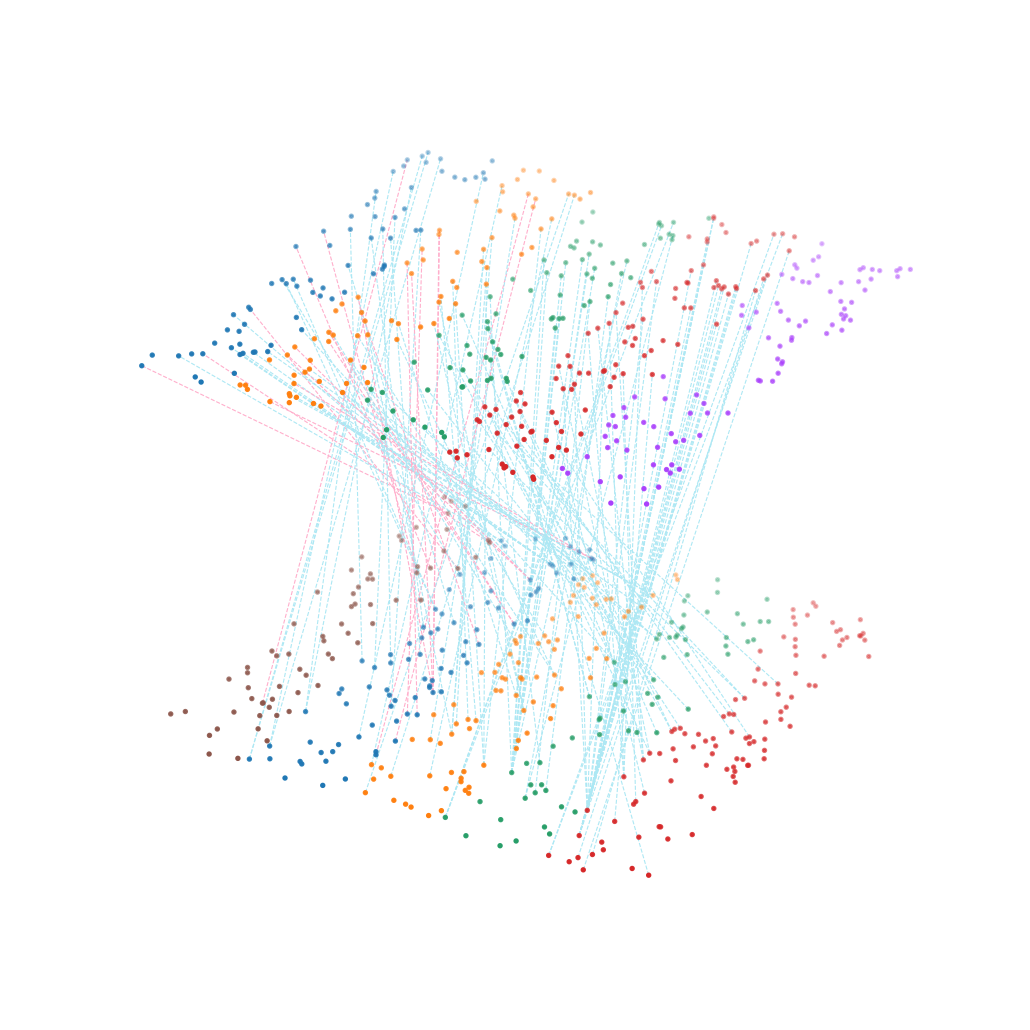

In [28]:
from utils.visualize import Build3D

multi_align = Build3D(adata2_harm_df, adata1_harm_df, matching_moscot, meta='domain', scale_coordinate=True,subsample_size=150, exchange_xy=False)
multi_align.draw_3D(size=[8, 10], line_width=0.5, point_size=[2, 2], line_alpha=1, hide_axis=True, show_error=True)

## PASTE Part

In [30]:
import paste as pst

sc.pp.pca(adata_sub1, n_comps=30)
sc.pp.pca(adata_sub2, n_comps=30)

In [31]:
import ot

pi0 = pst.match_spots_using_spatial_heuristic(adata_sub1.obsm['spatial'], adata_sub2.obsm['spatial'], use_ot=True)
pi_paste = pst.pairwise_align(adata_sub1, adata_sub2, G_init=pi0, alpha=0.3, dissimilarity='euc', use_rep='X_pca', norm=True, use_gpu=True, backend=ot.backend.TorchBackend())

gpu is available, using gpu.


In [32]:
count = 0
ref_raw_list = []
for i in range(pi_paste.shape[0]):
    source_domain = adata_sub1.obs['celltype'][i]
    max_align = pi_paste[i].argsort()[-1]
    target_domain = adata_sub2.obs['celltype'].values[max_align]
    ref_raw_list.append(max_align)

index_harm = np.array(ref_raw_list)
matching_harm_paste = np.array([range(index_harm.shape[0]), index_harm])

dataset1: 5 cell types; dataset2: 5 cell types; 
                    Total :6 celltypes; Overlap: 4 cell types 
                    Not overlap :[['Group6', 'Group5']]
Subsampled 150 pairs from 424


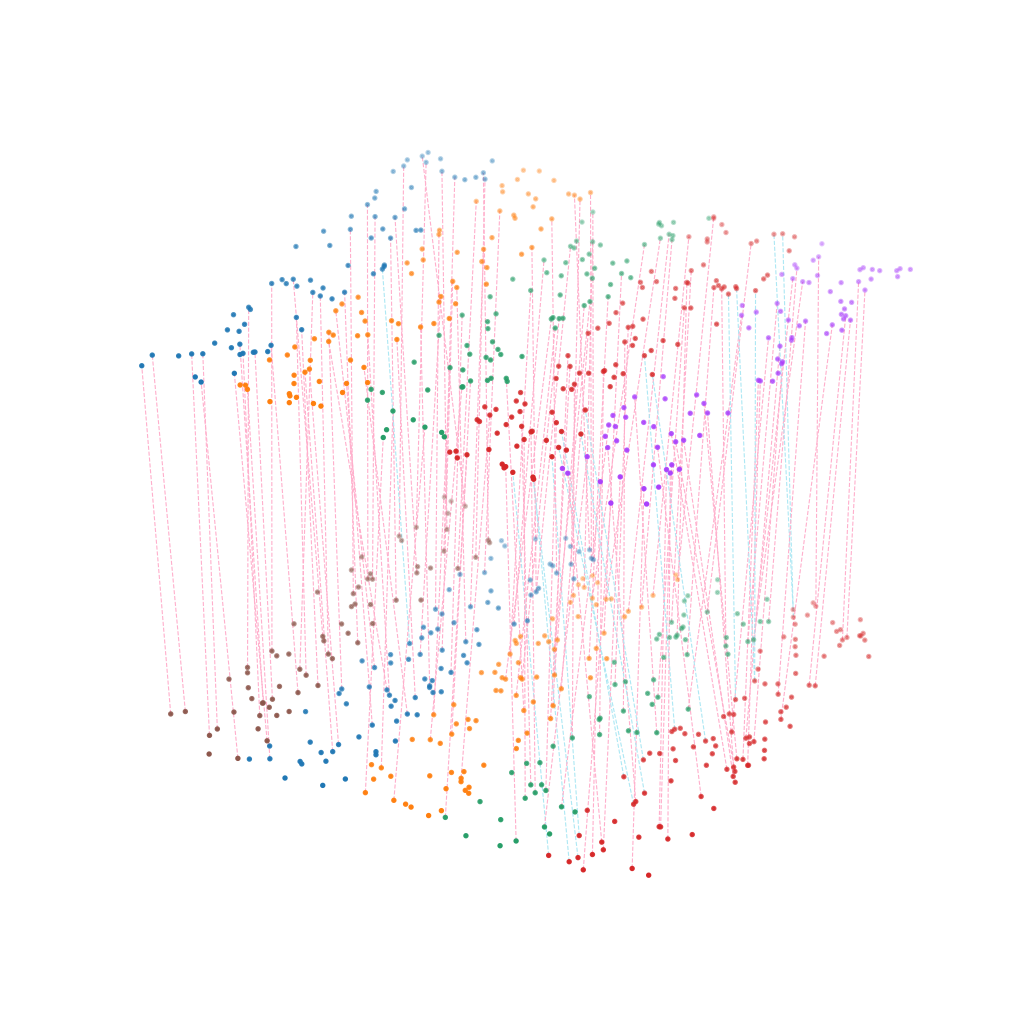

In [33]:
multi_align = Build3D(adata2_harm_df, adata1_harm_df, matching_harm_paste, meta='domain', scale_coordinate=True, subsample_size=150, exchange_xy=False)
multi_align.draw_3D(size=[8, 10], line_width=0.5, point_size=[2, 2], line_alpha=1, hide_axis=True, show_error=True, ) # save='figures/PASTE_simulate3_res.pdf'